In [1]:
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = 'C:\\study\\AI Training and Jobs\\NLP_CV_Course\\week_9\\' # Change me to store data elsewhere

In [17]:
def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified C:\study\AI Training and Jobs\NLP_CV_Course\week_9\notMNIST_large.tar.gz
Attempting to download: notMNIST_small.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified C:\study\AI Training and Jobs\NLP_CV_Course\week_9\notMNIST_small.tar.gz


In [3]:
num_classes = 10
np.random.seed(133)

In [19]:
def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        print('%s already present - Skipping extration of %s' % (root, filename))
    else:
        print("Extrating data for %s. This may take a while. Please wait." % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [os.path.join(root, d) for d in sorted(os.listdir(root)) if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception('Expected %d folders, one per class. Found %d instead.' % (num_classes, len(data_folders)))
    print(data_folders)
    return data_folders

train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extrating data for C:\study\AI Training and Jobs\NLP_CV_Course\week_9\notMNIST_large. This may take a while. Please wait.
['C:\\study\\AI Training and Jobs\\NLP_CV_Course\\week_9\\notMNIST_large\\A', 'C:\\study\\AI Training and Jobs\\NLP_CV_Course\\week_9\\notMNIST_large\\B', 'C:\\study\\AI Training and Jobs\\NLP_CV_Course\\week_9\\notMNIST_large\\C', 'C:\\study\\AI Training and Jobs\\NLP_CV_Course\\week_9\\notMNIST_large\\D', 'C:\\study\\AI Training and Jobs\\NLP_CV_Course\\week_9\\notMNIST_large\\E', 'C:\\study\\AI Training and Jobs\\NLP_CV_Course\\week_9\\notMNIST_large\\F', 'C:\\study\\AI Training and Jobs\\NLP_CV_Course\\week_9\\notMNIST_large\\G', 'C:\\study\\AI Training and Jobs\\NLP_CV_Course\\week_9\\notMNIST_large\\H', 'C:\\study\\AI Training and Jobs\\NLP_CV_Course\\week_9\\notMNIST_large\\I', 'C:\\study\\AI Training and Jobs\\NLP_CV_Course\\week_9\\notMNIST_large\\J']
Extrating data for C:\study\AI Training and Jobs\NLP_CV_Course\week_9\notMNIST_small. This may take a while

## Problem 1

In [32]:
def view_some_samples(folder):
    image_files = os.listdir(folder)
    for index, image_file in enumerate(image_files):
        if index % 20000 == 0:
            image_path = os.path.join(folder, image_file)
            display(Image(image_path, width=30, unconfined=True))

for train_folder in train_folders:
    view_some_samples(train_folder)

In [2]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

In [20]:
def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset


def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling C:\study\AI Training and Jobs\NLP_CV_Course\week_9\notMNIST_large\A.pickle.
C:\study\AI Training and Jobs\NLP_CV_Course\week_9\notMNIST_large\A
Could not read: C:\study\AI Training and Jobs\NLP_CV_Course\week_9\notMNIST_large\A\RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read: C:\study\AI Training and Jobs\NLP_CV_Course\week_9\notMNIST_large\A\SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read: C:\study\AI Training and Jobs\NLP_CV_Course\week_9\notMNIST_large\A\Um9tYW5hIEJvbGQucGZi.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825024
Standard deviation: 0.44312063
Pickling C:\study\AI Training and Jobs\NLP_CV_Course\week_9\notMNIST_large\B.pickle.
C:\study\AI Training and Jobs\NLP_CV_Course\week_9\notMNIST

## Problem 2

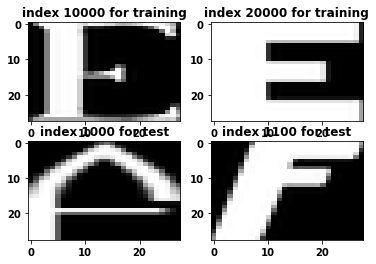

In [84]:
data_with_pickle = []
def verify_data(data):
    global data_with_pickle
    data_with_pickle = []
    with (open(data, "rb")) as f:
        data_with_pickle.append(pickle.load(f))

verify_data(train_datasets[4])
fig = plt.figure()
ex1 = fig.add_subplot(221)
ex1.set_title("index 10000 for training")
ex1.imshow(data_with_pickle[0][10000], aspect="auto", cmap='gray')
ex2 = fig.add_subplot(222)
ex2.set_title("index 20000 for training")
ex2.imshow(data_with_pickle[0][20000], aspect="auto", cmap='gray')


verify_data(test_datasets[5])
ex3 = fig.add_subplot(223)
ex3.set_title("index 1000 for test")
ex3.imshow(data_with_pickle[0][1000], aspect="auto", cmap='gray')
ex4 = fig.add_subplot(224)
ex4.set_title("index 1100 for test")
ex4.imshow(data_with_pickle[0][1100], aspect="auto", cmap='gray')

## Problem 3

In [49]:
def verify_data_balanced(data):
    global total_size
    with (open(data, "rb")) as f:
        temp = np.array(pickle.load(f), dtype= np.float32)
        len, _, _ = temp.shape
        data_size.append(len)
        total_size += len
verify_data_balanced(train_datasets[4])

In [98]:
## For training data evaluation
data_size = []
total_size = 0

for train_dataset in train_datasets:
    verify_data_balanced(train_dataset)
for value in data_size:
    print("The percentage quantity of training data is {}.".format(value / total_size))
    
    
## For training data evaluation 
data_size = []
total_size = 0

for test_dataset in test_datasets:
    verify_data_balanced(test_dataset)
for value in data_size:
    print("The percentage quantity of test data is {}.".format(value / total_size))

The percentage quantity of training data is 0.09999546411548361.
The percentage quantity of training data is 0.09999924401924727.
The percentage quantity of training data is 0.1000011339711291.
The percentage quantity of training data is 0.09999924401924727.
The percentage quantity of training data is 0.1000011339711291.
The percentage quantity of training data is 0.1000011339711291.
The percentage quantity of training data is 0.1000011339711291.
The percentage quantity of training data is 0.1000011339711291.
The percentage quantity of training data is 0.1000011339711291.
The percentage quantity of training data is 0.09999924401924727.
The percentage quantity of test data is 0.0999786370433668.
The percentage quantity of test data is 0.1000320444349498.
The percentage quantity of test data is 0.1000320444349498.
The percentage quantity of test data is 0.1000320444349498.
The percentage quantity of test data is 0.1000320444349498.
The percentage quantity of test data is 0.09997863704336

#### From the above infos, we know the data is balanced

In [3]:
character_arr = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
train_datasets = []
test_datasets = []
for value in character_arr:
    train_datasets.append(data_root + "notMNIST_large\\" + value + ".pickle")
    test_datasets.append(data_root + "notMNIST_small\\" + value + ".pickle")

In [4]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels

train_size = 100000
valid_size = 5000
test_size = 5000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (100000, 28, 28) (100000,)
Validation: (5000, 28, 28) (5000,)
Testing: (5000, 28, 28) (5000,)


In [5]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

## Problem 4

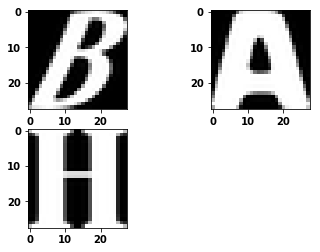

In [23]:
fig = plt.figure()
ex1 = fig.add_subplot(221)
ex1.imshow(train_dataset[40], cmap='gray')               ## Showing image sample of the training data
ex2 = fig.add_subplot(222)
ex2.imshow(test_dataset[80], cmap='gray')               ## Showing image sample of the test data
ex3 = fig.add_subplot(223)
ex3.imshow(valid_dataset[60], cmap='gray')               ## Showing image sample of the valid data

In [9]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [10]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 345400506


## Problem 5

In [3]:
file_name = 'notMNIST.pickle'
with open(data_root + file_name, 'rb') as f:
    data = pickle.load(f)

In [4]:
overlap = []
start = time.clock()
for value in data['valid_dataset']:
    overlap.append((data['train_dataset'] == [value]).all(axis=(1,2)).any(0))
    
for value in data['test_dataset']:
    overlap.append((data['train_dataset'] == [value]).all(axis=(1,2)).any(0))
    
for value in data['test_dataset']:
    overlap.append((data['valid_dataset'] == [value]).all(axis=(1,2)).any(0))
    
elapse = time.clock() - start
print("Elapsing time is {}".format(elapse))

C:\Users\WDMWDL\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


Elapsing time is 2779.739212842


C:\Users\WDMWDL\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


In [7]:
import pandas as pd
overlap_pd = pd.Series(overlap)

In [17]:
overlap_pd[overlap_pd].count()

773

#### From the above data, we konw the overlapping number is 773

## Problem 6

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score

### Passing training data with number of 50

In [46]:
image_size = 28
def train_model(data_len):
    train_data_real = data['train_dataset'][0:data_len].reshape(data_len, image_size * image_size)
    train_label_real = data['train_labels'][0:data_len]
    test_data_real = data['test_dataset'].reshape(len(data['test_dataset']), image_size * image_size)
    test_label_real = data['test_labels']

    clf_50 = LogisticRegression(random_state=24)
    clf_50.fit(train_data_real, train_label_real)
    print("The score is {} using training number of {}.".format(clf_50.score(test_data_real, test_label_real), data_len))

In [48]:
train_model(50)
train_model(100)
train_model(1000)
train_model(5000)

C:\Users\WDMWDL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\WDMWDL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


The score is 0.5978 using training number of 50.


C:\Users\WDMWDL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\WDMWDL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


The score is 0.7304 using training number of 100.


C:\Users\WDMWDL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\WDMWDL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


The score is 0.8188 using training number of 1000.


C:\Users\WDMWDL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\WDMWDL\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


The score is 0.8406 using training number of 5000.


In [23]:
import pyltp

ImportError: cannot import name 'Segmentor'